<h1>아래 꼭 import하고 진행하세요!</h1>

In [3]:

import sys
import os

# langgraph_project 디렉토리를 sys.path에 추가
project_root = os.path.abspath("..")  # unit_test의 상위 디렉토리
sys.path.append(project_root)

from chains.rag_chain import *
from vectorstore.pdf import PDFRetrievalChain
from tools.search import tavily_search
from langchain_core.prompts import load_prompt
from pathlib import Path
from dotenv import load_dotenv
from graph.workflow import build_workflow
from IPython.display import Image, display
from langchain_teddynote.messages import stream_graph, random_uuid
from langchain_core.runnables import RunnableConfig
from langchain.callbacks import tracing_v2_enabled


load_dotenv()
print(os.getenv('LANGCHAIN_ENDPOINT'))


q1 = '산업안전보건법 적용범위 판단기준'
q2 = '산업안전보건법을 전부 적용 가능하면 지방자치단체 소속 공무직 및 공공근로 등 단기간 근로자수를 합산하여 총 근로자수로 판단 가능한지?'

https://api.smith.langchain.com


Chain Test

In [4]:
# 1 확인 완료 (vector_websearch_chain)
print(vector_websearch_chain().invoke({"question": q1}))

next_node='vector'


In [5]:
# 2 확인 완료 (grade_documents_chain) >> 아래 generation 부분과 같이 확인 필요.
project_root = os.path.abspath("..")  # unit_test의 상위 디렉토리
pdf_path = os.path.join(
    project_root,
    "vectorstore", "data", "지방자치단체 산안법 적용 (산재예방정책과-3018 (2018.07.06. 시행).pdf"
)

pdf = PDFRetrievalChain([pdf_path]).create_chain()

# retriever 생성
pdf_retriever = pdf.retriever
# chain 생성
pdf_chain = pdf.chain

docs = pdf_retriever.invoke(q1)
print(len(docs))

filtered_docs = []

for doc in docs[:5]:
    res = grade_documents_chain().invoke(
        {"document": doc,
         "question": q2}
    )

    print('==============')
    print('[검토 내용]')
    print(doc)
    print('[판단 결과]')
    print(res)

    if res.pass_yn == "Y":
        filtered_docs.append(doc)

print(len(filtered_docs))


# 3 확인 완료 (generate_chain)

# 문서 포맷팅 함수
def format_docs(docs):
    return "\n\n".join(
        [
            f'<document><content>{doc.page_content}</content><source>{doc.metadata["source"]}</source><page>{doc.metadata["page"]+1}</page></document>'
            for doc in docs
        ]
    )
print('\n\n')
generation = generate_chain().invoke({"context": format_docs(filtered_docs), "question": q2})
print(generation)

CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
/Users/ranifarm/.conda/envs/adaptive-rag/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[DEBUG] embedding 객체 타입: <class 'langchain_huggingface.embeddings.huggingface.HuggingFaceEmbeddings'>
10
[검토 내용]
page_content='지방자치단체 고발사건 관련 중부청 질의에 대한 회신
□ 산업안전보건법의 적용범위 판단 기준
○ ｢산업안전보건법｣은 국가·지방자치단체를 포함하여 모든 사업 또는
사업장에 적용됨을 원칙(법 제3조)으로 하고 있으나
- 유해·위험의 정도, 사업의 종류 등을 고려하여 시행령 별표 1에서
정한 일부 사업에는 법의 일부규정을 적용하지 않고
- 특히, 공공행정, 교육서비스업 등에는 법 제2장(안전보건관리체제),
제3장(안전보건관리규정), 제31조(안전보건교육) 등을 적용제외로 규정함' metadata={'source': '/Users/ranifarm/python-work/adaptive-rag/vectorstore/data/지방자치단체 산안법 적용 (산재예방정책과-3018 (2018.07.06. 시행).pdf', 'file_path': '/Users/ranifarm/python-work/adaptive-rag/vectorstore/data/지방자치단체 산안법 적용 (산재예방정책과-3018 (2018.07.06. 시행).pdf', 'page': 0, 'total_pages': 3, 'Author': 'dw', 'CreationDate': "D:20241223160641+09'00'", 'Creator': 'Hwp 2022 12.0.0.2416', 'ModDate': "D:20241223160641+09'00'", 'PDFVersion': '1.4', 'Producer': 'Hancom PDF 1.3.0.545'}
[판단 결과]
pass_yn='N'
[검토 내용]
page_content='제3장(안전보건관리규정), 제31조(안전보건교육) 등을 적용제외로 규정함
○ ｢산업안전보건법｣은 그 적용단위가 “사업 또는 사업장”이며 사업
의 분류는 ｢통계법｣에 따

In [ ]:
# 4.확인 완료
grade_hallucination_chain().invoke({"documents": filtered_docs, "generation": generation})

GradeHallucinations(pass_yn='Y')

In [ ]:
# 5. 확인 완료
grade_answer_chain().invoke({"question": q2, "generation": generation})

GradeQuestionAnswer(pass_yn='Y')

In [3]:
# 6. 확인 완료
rewrite_query_chain().invoke({"question": q2})

AIMessage(content='산업안전보건법 적용 시 지방자치단체의 총 근로자 수 산정에 공무직과 단기 근로자를 포함할 수 있는지?', additional_kwargs={}, response_metadata={'id': 'msg_01Anqz75JS5VYdcWEDSz4tQi', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 207, 'output_tokens': 60, 'server_tool_use': None}, 'model_name': 'claude-3-5-sonnet-20240620'}, id='run--f531c424-32a0-4ec7-9072-5fbe8a22799f-0', usage_metadata={'input_tokens': 207, 'output_tokens': 60, 'total_tokens': 267, 'input_token_details': {'cache_read': 0, 'cache_creation': 0}})

tool test

In [2]:
tavily_search().invoke("AI 기사 찾아줘")

[{'title': 'AI와 관련된 뉴스기사나 신문기사 찾아줘 | 물어봐 AI - 요즘IT - 위시켓',
  'url': 'https://yozm.wishket.com/magazine/questions/share/hKcbDAsWdguIPFtK/',
  'content': '네, AI와 관련된 뉴스나 신문 기사를 찾아 볼게요. 요고가 신문을 찾는 데 시간이 좀 걸릴 거 같아서, 잠시 기다려 주시겠어요? 저는 이제 빠르게 신문기사를 찾아볼',
  'score': 0.68090034}]

graph drawing

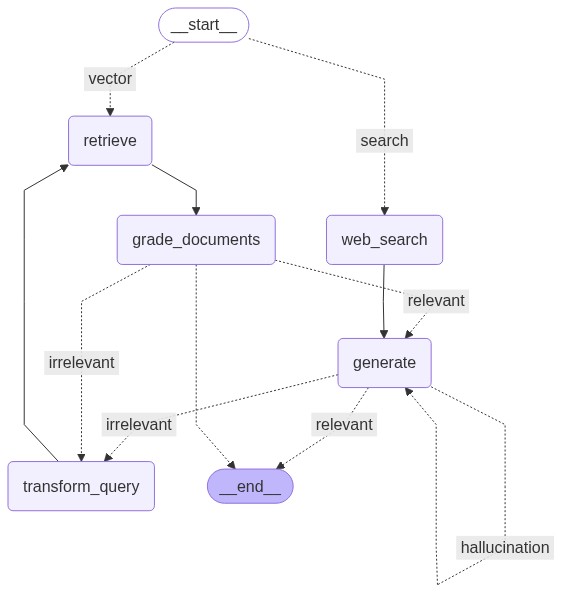

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	web_search(web_search)
	generate(generate)
	transform_query(transform_query)
	retrieve(retrieve)
	grade_documents(grade_documents)
	__end__([<p>__end__</p>]):::last
	__start__ -. &nbsp;vector&nbsp; .-> retrieve;
	__start__ -. &nbsp;search&nbsp; .-> web_search;
	generate -. &nbsp;relevant&nbsp; .-> __end__;
	generate -. &nbsp;irrelevant&nbsp; .-> transform_query;
	grade_documents -. &nbsp;relevant&nbsp; .-> generate;
	grade_documents -. &nbsp;irrelevant&nbsp; .-> transform_query;
	retrieve --> grade_documents;
	transform_query --> retrieve;
	web_search --> generate;
	grade_documents -.-> __end__;
	generate -. &nbsp;hallucination&nbsp; .-> generate;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



In [ ]:
from langchain_cli.langgraph import studio

project_root = os.path.abspath("..")  # unit_test의 상위 디렉토리
sys.path.append(project_root)

app = build_workflow()


try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

print((app.get_graph().draw_mermaid()))

In [3]:
# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "question": "범죄 개선",
}
# 그래프 실행
stream_graph(app, inputs, config)

======== [EDGE] ROUTE_VECTOR_OR_WEBSEARCH ========

🔄 Node: __start__ 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
[][{'id': 'toolu_01JeUbcKzYSfxffQfy8aJDMG', 'input': {}, 'name': 'RouteQuery', 'type': 'tool_use', 'index': 0}][{'partial_json': '', 'type': 'tool_use', 'index': 0}][{'partial_json': '{"ne', 'type': 'tool_use', 'index': 0}][{'partial_json': 'xt_node": ', 'type': 'tool_use', 'index': 0}][{'partial_json': '"search"}', 'type': 'tool_use', 'index': 0}]======== [ROUTE] SEARCH ========
======== [NODE] WEB_SEARCH ========
======== [NODE] GENERATE ========
{'question': '범죄 개선', 'documents': [Document(metadata={'source': 'https://www.korea.kr/news/policyNewsView.do?newsId=148913314'}, page_content='법무부는 “제1차 범죄예방 환경개선 기본계획의 수립·시행으로 범죄로부터 국민 불안을 해소하고 안전한 사회를 실현할 수 있도록 노력하겠다”고 밝혔다.'), Document(metadata={'source': 'https://www.moj.go.kr/moj/170/subview.do'}, page_content='주요 추진 내용 · 전국 9개 지역에서 범죄예방 환경개선사업 추진 · 지역 특색(외국인 집단 거주지, 유흥가 집집지 등), 주거 형태(원룸, 빌라, 아파트 등), 범죄 유형'), Docume

CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


======== [NODE] RETRIEVE ========


/Users/ranifarm/.conda/envs/adaptive-rag/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[DEBUG] embedding 객체 타입: <class 'langchain_huggingface.embeddings.huggingface.HuggingFaceEmbeddings'>
======== [NODE] GRADE DOCUMENTS ========

🔄 Node: grade_documents 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
[][{'id': 'toolu_01BTSZswemk6xVKWJ6CMDLEe', 'input': {}, 'name': 'GradeDocuments', 'type': 'tool_use', 'index': 0}][{'partial_json': '', 'type': 'tool_use', 'index': 0}][{'partial_json': '{"', 'type': 'tool_use', 'index': 0}][{'partial_json': 'pas', 'type': 'tool_use', 'index': 0}][{'partial_json': 's_yn": "N"}', 'type': 'tool_use', 'index': 0}]======== [NODE:CHECK] IRRELEVANT DOCUMENT ========
[][{'id': 'toolu_01TYzHjXHcamyD5yihvDozLk', 'input': {}, 'name': 'GradeDocuments', 'type': 'tool_use', 'index': 0}][{'partial_json': '', 'type': 'tool_use', 'index': 0}][{'partial_json': '{"pass_yn":', 'type': 'tool_use', 'index': 0}][{'partial_json': ' "N"}', 'type': 'tool_use', 'index': 0}]======== [NODE:CHECK] IRRELEVANT DOCUMENT ========
[][{'id': 'toolu_01WnkTXnghkhfMkuW4dg

CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


======== [NODE] RETRIEVE ========
[DEBUG] embedding 객체 타입: <class 'langchain_huggingface.embeddings.huggingface.HuggingFaceEmbeddings'>
======== [NODE] GRADE DOCUMENTS ========

🔄 Node: grade_documents 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
[][{'id': 'toolu_01M2eqrP8RiCWFiBPnDCK2Za', 'input': {}, 'name': 'GradeDocuments', 'type': 'tool_use', 'index': 0}][{'partial_json': '', 'type': 'tool_use', 'index': 0}][{'partial_json': '{"pass_y', 'type': 'tool_use', 'index': 0}][{'partial_json': 'n": "N"}', 'type': 'tool_use', 'index': 0}]======== [NODE:CHECK] IRRELEVANT DOCUMENT ========
[][{'id': 'toolu_01J8z831iqbBy6UBstL9DjN4', 'input': {}, 'name': 'GradeDocuments', 'type': 'tool_use', 'index': 0}][{'partial_json': '', 'type': 'tool_use', 'index': 0}][{'partial_json': '{"p', 'type': 'tool_use', 'index': 0}][{'partial_json': 'ass_yn": "', 'type': 'tool_use', 'index': 0}][{'partial_json': 'N"}', 'type': 'tool_use', 'index': 0}]======== [NODE:CHECK] IRRELEVANT DOCUMENT ========
[][

GraphRecursionError: Recursion limit of 10 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT